# Atividade vivencial - Aprendizado profundo

Neste notebook iremos utilizar a biblioteca [Keras](https://www.keras.io) para construir redes neurais do tipo Convolutional Neural Networks (CNNs). Revisitaremos a implementação da CNN do módulo 6, mas para outro dataset. Em particular, iremos criar uma CNN para classificar imagens do dataset CIFAR-100. As imagens deste dataset são classificadas em 100 classes. Para facilitar nosso trabalho, consideraremos um agrupamento destas classes em 20 super-classes.

Nosso objetivo aqui é entender melhor como uma CNN funciona. Ao final, você deverá realizar os exercícios propostos.

Para começar, precisamos importar algumas bibliotecas básicas: `numpy` para lidar com operações numéricas, `matplotlib` para criar gráficos e `keras` para criar redes neurais.

In [ ]:
import keras
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Para utilizar o dataset em questão, basta executar o comando abaixo.  Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída).

In [ ]:
# carrega os conjuntos de treino e teste
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

169017344/169001437 [==============================] - 14s 0us/step


Podemos visualizar alguns exemplos (entrada e saída) do dataset utilizando o código abaixo.

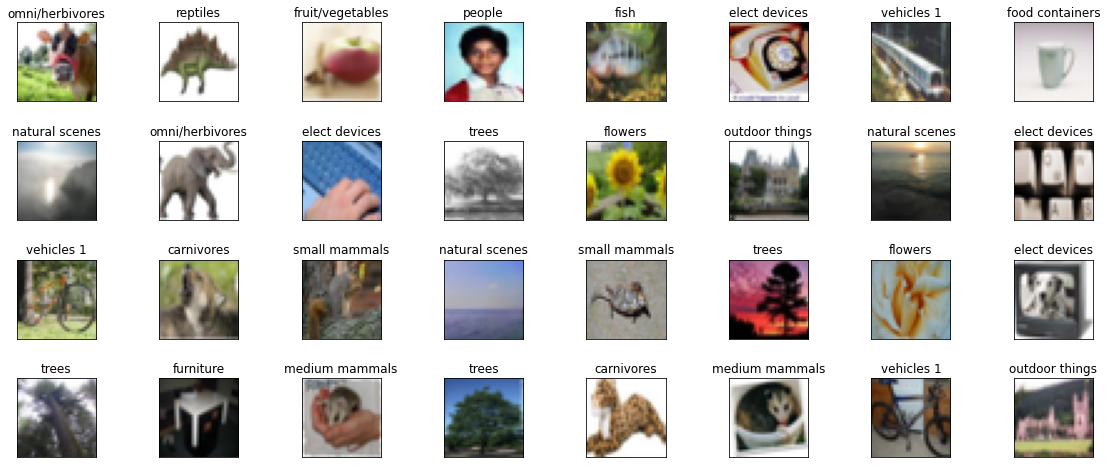

In [ ]:
cifar100_labels = ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit/vegetables', 'elect devices', 'furniture', 'insects', 'carnivores', 'outdoor things', 'natural scenes', 'omni/herbivores', 'medium mammals', 'invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']

fig = plt.figure(figsize=(20, 8))
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(cifar100_labels[y_train[i][0]]))

fig.subplots_adjust(hspace=0.5)

Após carregar os dados, devemos tratá-los para melhorar o treinamento. No nosso caso, vamos apenas normalizar as cores (atualmente no intervalo [0,255]) para o intervalo [0,1].

In [ ]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Em seguida, podemos codificar as classes utilizando o one-hot encoding. Isto vai facilitar a tarefa de aprendizado.

In [ ]:
# codificação one-hot das categorias
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Outro passo importante é separar uma parte do conjunto de treino para validação. O objetivo é reduzir o bias do conjunto de teste.

In [ ]:
# divide os dados em treino, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Após os tratamentos acima, podemos identificar o formato resultante dos nossos dados com os comandos abaixo.

In [ ]:
# imprime o formato dos dados de entrada
print('formato dos dados de entrada:', x_train.shape)

# imprime o tamanho dos conjuntos
print(x_train.shape[0], 'amostras de treino')
print(x_valid.shape[0], 'amostras de validação')
print(x_test.shape[0], 'amostras de teste')

formato dos dados de entrada: (45000, 32, 32, 3)
45000 amostras de treino
5000 amostras de validação
10000 amostras de teste


Processados os dados, agora devemos criar a CNN. Como de costume, trabalharemos com um modelo sequencial.

In [ ]:
model = Sequential()

Em seguida, podemos empilhar as camadas de convolução e agrupamento desejadas. Neste nosso caso, estamos trabalhando com 3 camadas convolucionais, cada qual com kernel de tamanho 2x2 e função de ativação ReLU. Após cada camada convolucional empilhamos uma camada de max pooling com kernel de tamanho 2x2.

In [ ]:
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

Lembre-se que as camadas convolucionais servem como um extrator de features, as quais serão utilizadas por um classificador MLP. Desta forma, agora precisamos converter a saída da parte convolucional para um vetor, que é o formato aceito por uma MLP. Isto pode ser feito com uma camada `Flatten`, como abaixo.

In [ ]:
model.add(Flatten())

Finalmente, agora podemos adicionar as camadas densas de uma MLP para realizar a classificação. Note também que estamos utilizando Dropout para reduzir o overfitting.

In [ ]:
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20, activation='softmax'))

Nossa rede resultante é resumida abaixo.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

O próximo passo é compilar nosso modelo. Os parâmetros abaixo foram escolhidos por serem próprios para classificação.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Agora podemos finalmente treinar nosso modelo. **Cuidado, este processo pode demorar bastante!**  Para facilitar o estudo, reduzimos o número de épocas para apenas 20. Tente aumentar o número de épocas para ver entender melhor o efeito deste parâmetro nos resultados.

Note que antes do treino, criamos um checkpoint. Um checkpoint permite que o modelo seja salvo em um arquivo. No nosso caso, apenas o melhor modelo será salvo. Desta forma, poderemos carregar nosso modelo posteriormente sem precisar treinar novamente a rede.

In [ ]:
# cria um checkpoint para salvar os pesos do melhor modelo encontrado no trainamento
checkpointer = ModelCheckpoint(filepath='model.weights.best.h5', verbose=1, save_best_only=True)

# treina o modelo
hist = model.fit(x_train, y_train, batch_size=32, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer],
          verbose=2, shuffle=True)

Epoch 1/20

Epoch 1: val_loss improved from inf to 2.30230, saving model to model.weights.best.h5
1407/1407 - 18s - loss: 2.5696 - accuracy: 0.1999 - val_loss: 2.3023 - val_accuracy: 0.2904 - 18s/epoch - 13ms/step
Epoch 2/20

Epoch 2: val_loss improved from 2.30230 to 2.08808, saving model to model.weights.best.h5
1407/1407 - 6s - loss: 2.2707 - accuracy: 0.2990 - val_loss: 2.0881 - val_accuracy: 0.3540 - 6s/epoch - 5ms/step
Epoch 3/20

Epoch 3: val_loss improved from 2.08808 to 2.01153, saving model to model.weights.best.h5
1407/1407 - 7s - loss: 2.1347 - accuracy: 0.3395 - val_loss: 2.0115 - val_accuracy: 0.3738 - 7s/epoch - 5ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 2.01153
1407/1407 - 7s - loss: 2.0469 - accuracy: 0.3639 - val_loss: 2.0630 - val_accuracy: 0.3674 - 7s/epoch - 5ms/step
Epoch 5/20

Epoch 5: val_loss improved from 2.01153 to 1.89455, saving model to model.weights.best.h5
1407/1407 - 7s - loss: 1.9771 - accuracy: 0.3887 - val_loss: 1.8945 - val_accuracy

Treinado o modelo, podemos analisar seu desempenho através dos gráficos abaixo.

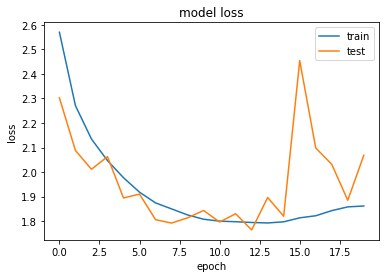

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

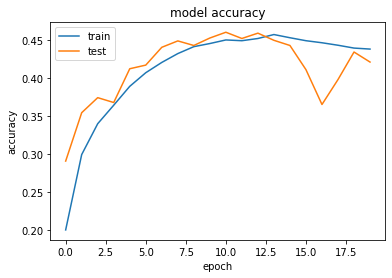

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como pode ser observado, nossa rede CNN conseguiu obter resultados bem interessantes mesmo sem uma otimização dos hiper-parâmetros.

Após concluir o treino, podemos carregar o melhor modelo utilizando o comando abaixo.

In [ ]:
# carrega os pesos do melhor modelo encontrado no treinamento
model.load_weights('model.weights.best.h5')

A acurácia pode ser medida como segue.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.46320000290870667


Finalmente, podemos visualizar algumas predições do nosso modelo para entender melhor seu comportamento.

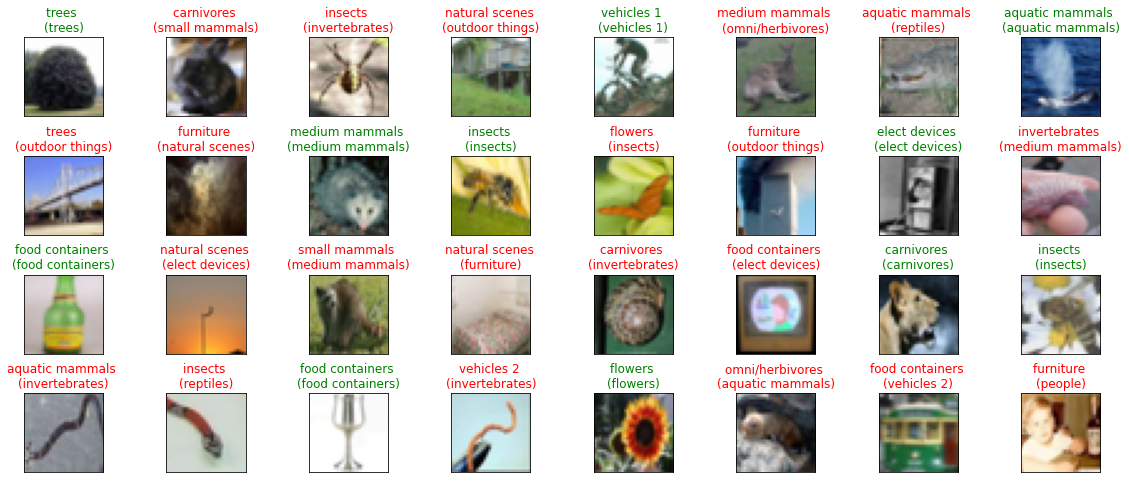

In [ ]:
# obtém as predições
y_hat = model.predict(x_test)

# exibe alguns exemplos aleatórios do teste, bem como sua predição e o resultado esperado
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} \n({})".format(cifar100_labels[pred_idx], cifar100_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

fig.subplots_adjust(hspace=0.5)

## Exercícios

### Exercício 1

Teste diferentes combinações de hiper-parâmetros (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.) para a CNN criada acima. Em seguida, crie uma tabela relacionado as combinações de hiper-parâmetros testadas e os resultados obtidos. Ao final, indique a melhor combinação.

| Camada 1 | Camada 2   | Camada 3 | Camada 4   | Camada 5  | Camada 6   | Camada 7  | Camada 8  | Camada 9    | Camada 10  | Otimizador  | Episódios | Acurácia | Melhor? |
| ---      | ---        | ---      | ---        | ---       | ---        | ---       | ---       | ---         | ---        | ---         | ---       | ---      | ---     |
| Conv16   | MaxP       | Conv32   | MaxP       | Conv64    | MaxP       | Flatten   | Dense100  | Dropout0.4  | Dense20    | RMSprop     | 20        | 0.4632   | ✗       |
| Conv32   | MaxP       | Conv64   | MaxP       | Conv128   | MaxP       | Flatten   | Dense100  | Dropout0.4  | Dense20    | RMSprop     | 20        | 0.4918   | ✗       |
| Conv32   | MaxP       | Conv64   | MaxP       | Conv128   | MaxP       | Flatten   | Dense100  | Dropout0.4  | Dense20    | Adam(0.001) | 20        | 0.5160   | ✗       |
| Conv32   | MaxP       | Conv64   | MaxP       | Conv128   | MaxP       | Flatten   | Dense100  | Dropout0.2  | Dense20    | Adam(0.001) | 20        | 0.5172   | ✗       |
| Conv32   | MaxP       | Conv64   | MaxP       | Conv128   | MaxP       | Flatten   | Dense100  | Dropout0.2  | Dense20    | Adam(0.001) | 30        | 0.5105   | ✗       |
| Conv32   | MaxP     | Conv64     | MaxP       | Conv128   | MaxP        | Flatten    | Dense256    | Dropout0.2| Dense20  | Adam(0.001) | 30     | 0.5428   | ✔       |

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 623,828 (2.38 MB)

 Trainable params: 623,380 (2.38 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30

Epoch 1: val_loss improved from inf to 2.12279, saving model to model.weights.best.keras
1407/1407 - 14s - 10ms/step - accuracy: 0.2904 - loss: 2.3285 - val_accuracy: 0.3384 - val_loss: 2.1228
Epoch 2/30

Epoch 2: val_loss improved from 2.12279 to 1.87308, saving model to model.weights.best.keras
1407/1407 - 13s - 9ms/step - accuracy: 0.4123 - loss: 1.8872 - val_accuracy: 0.4094 - val_loss: 1.8731
Epoch 3/30

Epoch 3: val_loss improved from 1.87308 to 1.68746, saving model to model.weights.best.keras
1407/1407 - 5s - 4ms/step - accuracy: 0.4772 - loss: 1.6642 - val_accuracy: 0.4592 - val_loss: 1.6875
Epoch 4/30

Epoch 4: val_loss improved from 1.68746 to 1.63234, saving model to model.weights.best.keras
1407/1407 - 4s - 3ms/step - accuracy: 0.5280 - loss: 1.4982 - val_accuracy: 0.4892 - val_loss: 1.6323
Epoch 5/30

Epoch 5: val_loss did not improve from 1.63234
1407/1407 - 4s - 3ms/step - accuracy: 0.5734 - loss: 1.3349 - val_accuracy: 0.4436 - val_loss: 1.8580
Epoch 6/30



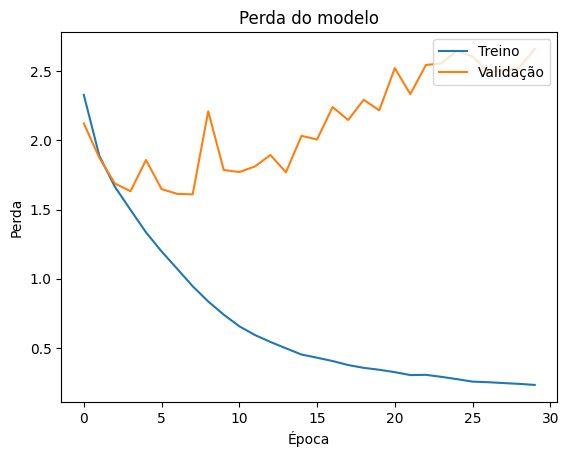

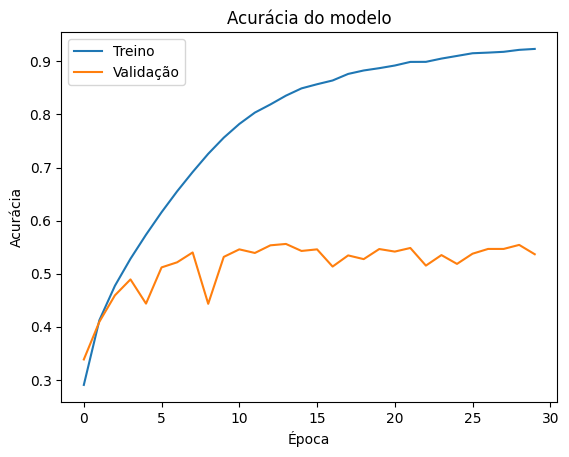


 Acurácia no teste: 0.5428000092506409
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


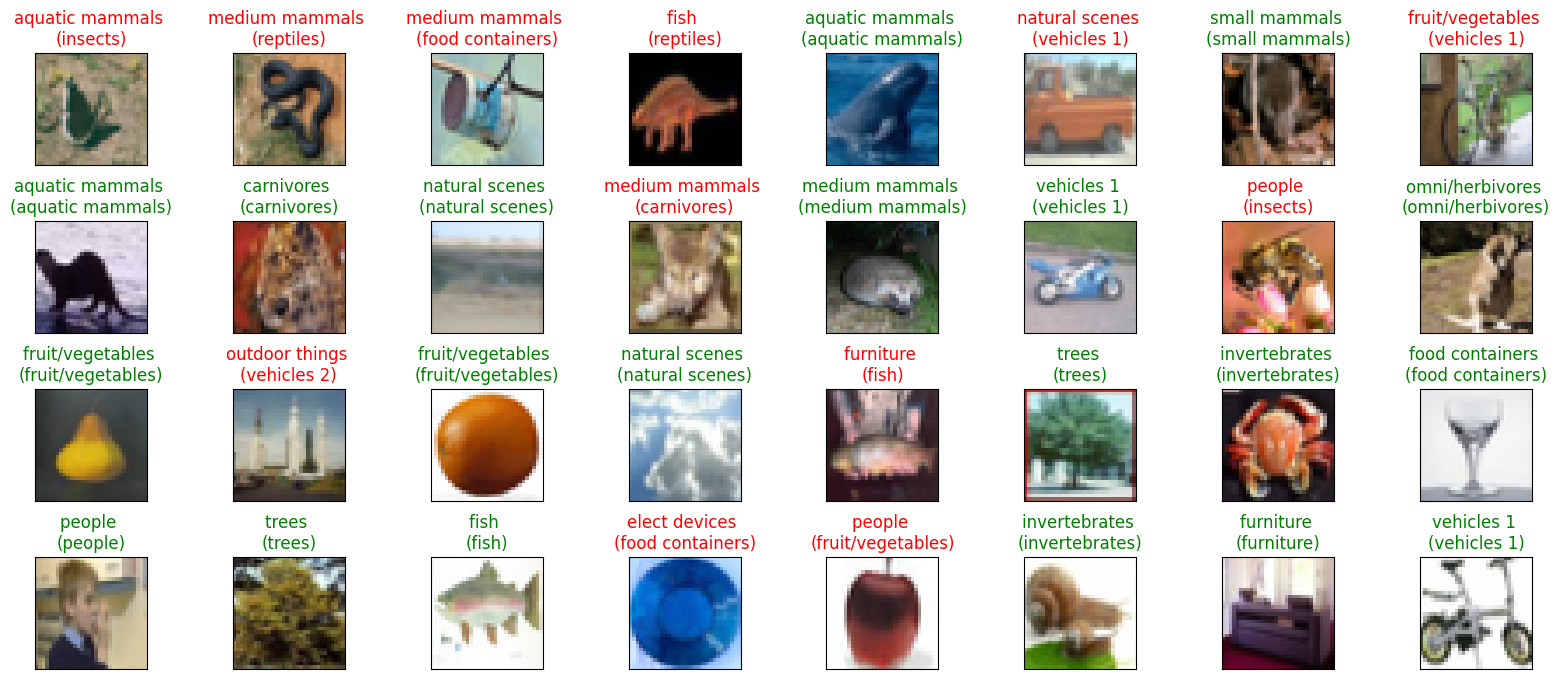

In [9]:
import keras
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

num_classes = len(np.unique(y_train))
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=32, epochs=30,
                 validation_data=(x_valid, y_valid), callbacks=[checkpointer],
                 verbose=2, shuffle=True)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

model.load_weights('model.weights.best.keras')

score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia no teste:', score[1])

y_hat = model.predict(x_test)

cifar100_labels = ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit/vegetables',
                   'elect devices', 'furniture', 'insects', 'carnivores', 'outdoor things',
                   'natural scenes', 'omni/herbivores', 'medium mammals', 'invertebrates',
                   'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']

fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} \n({})".format(cifar100_labels[pred_idx], cifar100_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

fig.subplots_adjust(hspace=0.5)
plt.show()